In [1]:
import pandas as pd

In [2]:
from dateutil import parser

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [4]:

# load the original data
og_news = pd.read_csv(
    r"C:\Users\THINKPAD\Desktop\10_Academy\Week_1\week_one_project\data\newsData\raw_analyst_ratings.csv",
    parse_dates=["date"]
)
print(og_news.shape);
print(og_news.dtypes)
print(og_news.head())

(1407328, 6)
Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vi

In [5]:
#copy the original data 
news = og_news.copy()
print("Initial shape:", news.shape)

Initial shape: (1407328, 6)


Convert dates but do not drop rows yet

In [6]:

def safe_parse(x):
    try:
        return parser.parse(str(x))
    except:
        return pd.NaT

news['date'] = og_news['date'].apply(safe_parse)


In [7]:

# Count invalid dates
num_invalid_dates = news['date'].isna().sum()
print("Number of invalid dates (NaT) after safe parsing:", num_invalid_dates)

Number of invalid dates (NaT) after safe parsing: 0


Inspect missing values in headline and stock without dropping

In [9]:
missing_headline = news['headline'].isna().sum()
missing_stock = news['stock'].isna().sum()
print("Missing headlines:", missing_headline)
print("Missing stocks:", missing_stock)


Missing headlines: 0
Missing stocks: 0


Normalize publisher names

In [10]:
news['publisher_norm'] = news['publisher'].str.lower().str.strip()
print(news[['publisher', 'publisher_norm']].head())


           publisher     publisher_norm
0  Benzinga Insights  benzinga insights
1  Benzinga Insights  benzinga insights
2         Lisa Levin         lisa levin
3         Lisa Levin         lisa levin
4         Vick Meyer         vick meyer


Calculate headline length

In [11]:
news['headline_len'] = news['headline'].astype(str).str.len()
print(news[['headline', 'headline_len']].head())


                                            headline  headline_len
0            Stocks That Hit 52-Week Highs On Friday            39
1         Stocks That Hit 52-Week Highs On Wednesday            42
2                      71 Biggest Movers From Friday            29
3       46 Stocks Moving In Friday's Mid-Day Session            44
4  B of A Securities Maintains Neutral on Agilent...            87


Extract date parts

In [12]:
news['date'] = pd.to_datetime(news['date'], errors='coerce', utc=True)


In [13]:
news['date_only'] = news['date'].dt.date
news['hour'] = news['date'].dt.hour
news['weekday'] = news['date'].dt.day_name()
print(news[['date', 'date_only', 'hour', 'weekday']].head())


                       date   date_only  hour    weekday
0 2020-06-05 14:30:54+00:00  2020-06-05    14     Friday
1 2020-06-03 14:45:20+00:00  2020-06-03    14  Wednesday
2 2020-05-26 08:30:07+00:00  2020-05-26     8    Tuesday
3 2020-05-22 16:45:06+00:00  2020-05-22    16     Friday
4 2020-05-22 15:38:59+00:00  2020-05-22    15     Friday


Drop rows with empty headline and stock

In [14]:
news_clean = news.dropna(subset=['headline', 'stock'])
print("Shape after dropping missing headline/stock:", news_clean.shape)


Shape after dropping missing headline/stock: (1407328, 11)


In [18]:
print(news_clean.head)
news_clean.to_csv(r"C:\Users\THINKPAD\Desktop\10_Academy\Week_1\week_one_project\data\newsData\news_clean.csv", index=False)


<bound method NDFrame.head of          Unnamed: 0                                           headline  \
0                 0            Stocks That Hit 52-Week Highs On Friday   
1                 1         Stocks That Hit 52-Week Highs On Wednesday   
2                 2                      71 Biggest Movers From Friday   
3                 3       46 Stocks Moving In Friday's Mid-Day Session   
4                 4  B of A Securities Maintains Neutral on Agilent...   
...             ...                                                ...   
1407323     1413844             Top Narrow Based Indexes For August 29   
1407324     1413845  Recap: Wednesday's Top Percentage Gainers and ...   
1407325     1413846  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1407326     1413847  Oppenheimer Initiates China Zenix At Outperfor...   
1407327     1413848  China Zenix Auto International Opens For Tradi...   

                                                       url          publisher  \


Headline lengths

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_len, dtype: float64


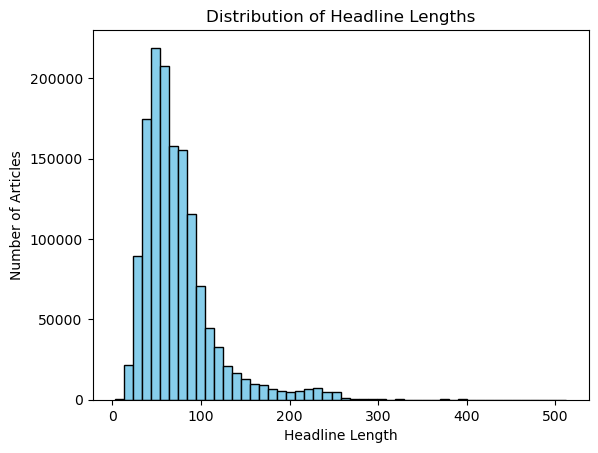

In [68]:
# Basic stats for headline length
print(news['headline_len'].describe())

#  histogram to visualize
import matplotlib.pyplot as plt

plt.hist(news['headline_len'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Headline Lengths")
plt.xlabel("Headline Length")
plt.ylabel("Number of Articles")
plt.show()


Count per Publisher

publisher_domain
paul quintaro        228373
lisa levin           186979
benzinga newsdesk    150484
charles gross         96732
monica gerson         82380
eddie staley          57254
hal lindon            49047
etf professor         28489
juan lopez            28438
benzinga staff        28114
Name: count, dtype: int64


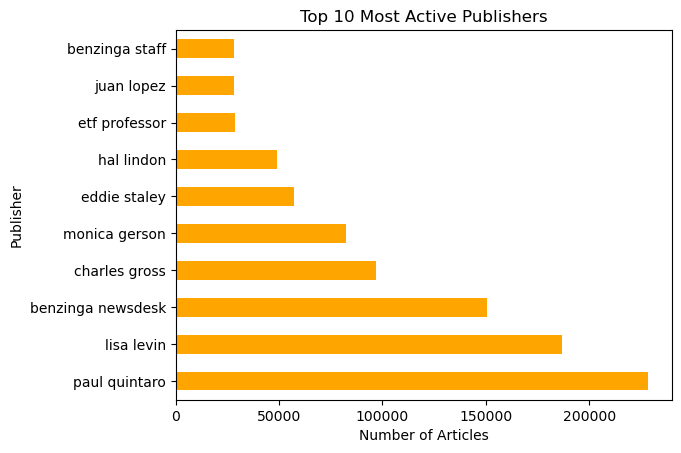

In [69]:
publisher_counts = news['publisher_domain'].value_counts()
print(publisher_counts.head(10))  # top 10 most active publishers

# Optional: bar chart
publisher_counts.head(10).plot(kind='barh', color='orange')
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.title("Top 10 Most Active Publishers")
plt.show()


Analyze Publication Date

date_only
2009-02-14    1
2009-04-27    2
2009-04-29    1
2009-05-22    1
2009-05-27    6
dtype: int64


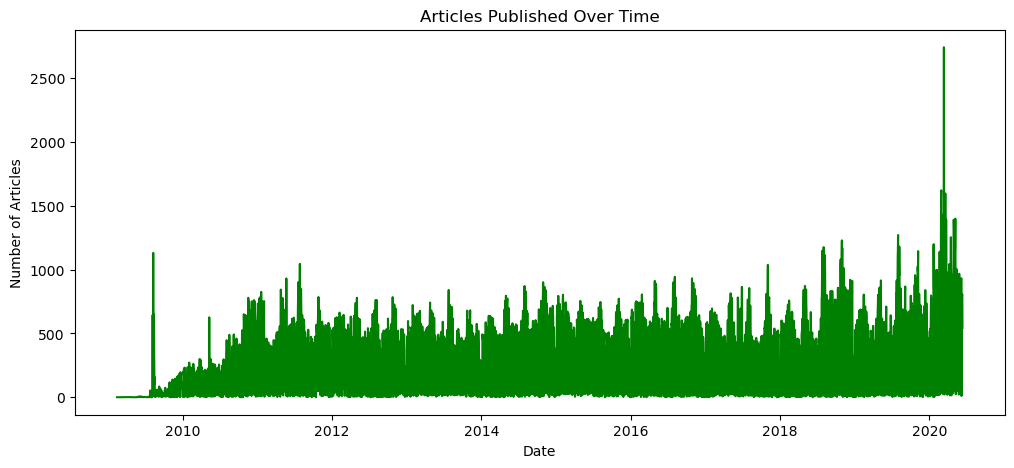

In [70]:
# Number of articles per day
articles_per_day = news.groupby('date_only').size()
print(articles_per_day.head())

# Optional: line chart over time
articles_per_day.plot(figsize=(12,5), color='green')
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Articles Published Over Time")
plt.show()


Text Analysis 

In [78]:


# Only consider top 50 keywords
vectorizer = CountVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(news['headline'].astype(str))

# Show top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)



lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

for i, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"Topic {i+1}: {top_words}")



Top Keywords: ['00' '10' '52' 'announces' 'bank' 'benzinga' 'buy' 'companies' 'company'
 'coverage' 'day' 'downgrades' 'earnings' 'energy' 'eps' 'est' 'estimate'
 'higher' 'initiates' 'lower' 'lowers' 'maintains' 'market' 'mid' 'moving'
 'neutral' 'new' 'price' 'pt' 'q1' 'q2' 'q3' 'q4' 'raises' 'reports'
 'sales' 'says' 'scheduled' 'sees' 'session' 'share' 'shares' 'stock'
 'stocks' 'target' 'trading' 'update' 'upgrades' 'vs' 'week']
Topic 1: ['stock', 'company', 'scheduled', 'share', 'lower', 'companies', 'higher', 'trading', 'earnings', 'shares']
Topic 2: ['energy', 'shares', 'moving', 'benzinga', 'session', 'day', 'mid', 'update', 'stocks', 'market']
Topic 3: ['bank', 'neutral', 'initiates', 'maintains', '00', 'raises', 'upgrades', 'downgrades', 'buy', 'pt']
Topic 4: ['stock', '10', 'says', 'announces', 'new', 'target', '52', 'stocks', 'price', 'week']
Topic 5: ['q2', 'estimate', 'sees', 'q1', 'q4', 'sales', 'reports', 'eps', 'est', 'vs']


Time Series Analysis

Articles per hour of the day

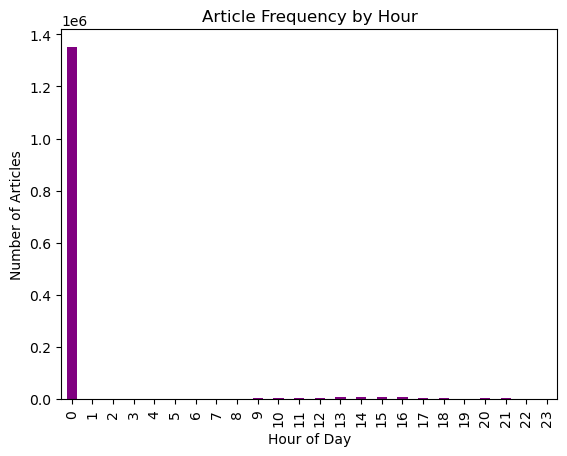

In [79]:
articles_per_hour = news.groupby('hour').size()
articles_per_hour.plot(kind='bar', color='purple')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Articles")
plt.title("Article Frequency by Hour")
plt.show()


Articles per weekday

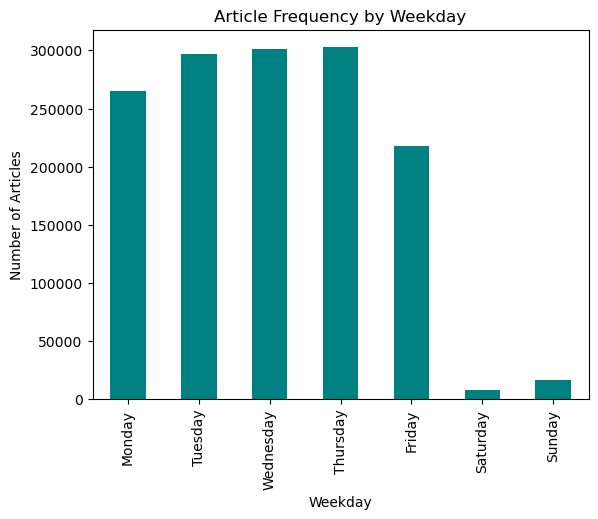

In [80]:
articles_per_weekday = news.groupby('weekday').size().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
articles_per_weekday.plot(kind='bar', color='teal')
plt.xlabel("Weekday")
plt.ylabel("Number of Articles")
plt.title("Article Frequency by Weekday")
plt.show()


Publisher Analysis

Top publisher by Article type

In [81]:
publisher_types = news.groupby('publisher_domain')['headline_len'].describe()
print(publisher_types.head(10))


                     count       mean        std   min   25%   50%    75%  \
publisher_domain                                                            
47ertrends            18.0  47.000000   0.000000  47.0  47.0  47.0   47.0   
aakin                  5.0  35.600000  10.237187  24.0  26.0  40.0   40.0   
aaron jackson.ed      16.0  37.187500   9.410765  21.0  34.0  35.0   48.0   
aaron levitt         295.0  36.274576  12.798910  13.0  26.0  34.0   44.0   
aarp                   7.0  56.000000   0.000000  56.0  56.0  56.0   56.0   
abe raymond         1464.0  54.675546  21.497888  18.0  46.0  47.0   57.0   
abhi rao             146.0  45.746575  12.062945  27.0  36.0  47.0   51.0   
abigail field         24.0  58.125000  13.326380  40.0  44.0  62.0   74.0   
abnnewswire           13.0  92.615385  24.067746  73.0  73.0  87.0   94.0   
above average odds    20.0  80.100000  42.577360  26.0  45.0  69.0  123.5   

                      max  
publisher_domain           
47ertrends         

Email domain Analysis

In [82]:
email_domains = news['publisher_domain'].value_counts()
print(email_domains.head(10))  # shows which organizations dominate


publisher_domain
paul quintaro        228373
lisa levin           186979
benzinga newsdesk    150484
charles gross         96732
monica gerson         82380
eddie staley          57254
hal lindon            49047
etf professor         28489
juan lopez            28438
benzinga staff        28114
Name: count, dtype: int64
